# **TR_2021/19 - Technical report: Poisson regression for cardiovascular hospitalizations and extreme events**


|Technical Report ID  |2021/xx|
|--|--|
| Title |Poisson regression for cardiovascular hospitalizations and extreme events|
| Authors | Júlia De Lázari, Paula Dornhofer|
| Creation Date| 2021-09|


## Databases descriptions

**inputs:** 

- hospitalizações_circulatorio.csv: Dataframe of hospitalizations due to cardiovascular diseases from 2014 to 2018.

- EV_VCP.csv: Dataframe with the extreme events computed. Viracopos data was used for this.

## Analysis

This report presents an analysis of the the _relative risk_ for the [extreme climate events](https://github.com/climate-and-health-datasci-Unicamp/project-climatic-variations-cardiovascular-diseases/blob/main/notebooks/TR_2020_05_Extreme_climatic_events_for_Campinas.ipynb) using a case crossover design.

##**Poisson regression**

Poisson regression was used to estimate the relative risk associated with each extreme event. The Poisson regression is used to model counts and was used to model the daily number of deaths and hospitalizations. As the mean and variance are not equal, we used a generalized Poisson regression [Consul]. In this model, the probability of observing k events is given by:

$$P_y(y=k) = \frac{e^{-(\lambda + \alpha*k)*(\lambda + \alpha*k)^{k-1}}}{k!}$$

And the mean and variance:

$$\mbox{mean(y)} = \frac{\lambda}{(1-\alpha)} \hspace{50pt} \mbox{variance(y)} = \frac{\lambda}{(1-\alpha)^3}$$

We included the other meteorological parameters, a categorical variable for the day of the week, the month, and the month and year. After an exploratory analysis of these variables and their p-value, we chose to keep the day of the week, STRATA (month and year), minimum temperature, average pressure for all the regression.

##**Import libraries**

In [1]:
#-------------------------------------------------------------------#
#                       Import libraries                            #
#-------------------------------------------------------------------#
import pandas as pd
import numpy as np
import datetime
import more_itertools as mit
import datetime
import statistics as stat
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy
import seaborn as sns
sns.set()
import pylab
from datetime import timedelta
from calendar import isleap
from patsy import dmatrices
import statsmodels as stat
import statsmodels.api as sm
import statsmodels.formula.api as smf

from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


##**Load data**

###**Climatic data**

In [2]:
#-------------------------------------------------------------------#
#                          Load Viracopos data                      #
#-------------------------------------------------------------------#

#Load humidity dataframe
df_vir = pd.read_csv('EV_VCP.csv')
df_vir = df_vir.drop(columns = {'Unnamed: 0'})
df_vir['DATE'] = pd.to_datetime(df_vir['DATE'])
df_vir['YEAR'] = df_vir['DATE'].dt.strftime('%Y') #create column for year

In [3]:
print("Percentage of null values VCP (1983-2018) \n")

print("TMIN:", round((len(df_vir[df_vir['TMIN'].isnull()]))/len(df_vir)*100,2),"%")
print("TMAX:", round((len(df_vir[df_vir['TMAX'].isnull()]))/len(df_vir)*100,2),"%")
print("AVGPRESSURE:", round((len(df_vir[df_vir['AVGPRESSURE'].isnull()]))/len(df_vir)*100,2),"%")
print("HMIN:", round((len(df_vir[df_vir['HMIN'].isnull()]))/len(df_vir)*100,2),"%")
print("HMAX:", round((len(df_vir[df_vir['HMAX'].isnull()]))/len(df_vir)*100,2),"%")

print("\n")

print("Number of null rows \n")

print("TMIN:", len(df_vir[df_vir['TMIN'].isnull()]))
print("TMAX:", len(df_vir[df_vir['TMAX'].isnull()]))
print("AVGPRESSURE:",len(df_vir[df_vir['AVGPRESSURE'].isnull()]))
print("HMIN:", len(df_vir[df_vir['HMIN'].isnull()]))
print("HMAX:", len(df_vir[df_vir['HMAX'].isnull()]))

Percentage of null values VCP (1983-2018) 

TMIN: 0.18 %
TMAX: 0.18 %
AVGPRESSURE: 0.02 %
HMIN: 0.05 %
HMAX: 0.05 %


Number of null rows 

TMIN: 12
TMAX: 12
AVGPRESSURE: 1
HMIN: 3
HMAX: 3


In [4]:
#fill na 
df_vir['HMIN'].fillna(df_vir['HMIN'].mean(), inplace=True)
df_vir['HMAX'].fillna(df_vir['HMAX'].mean(), inplace=True)
df_vir['TMIN'].fillna(df_vir['TMIN'].mean(), inplace=True)
df_vir['TMAX'].fillna(df_vir['TMAX'].mean(), inplace=True)
df_vir['AVGPRESSURE'].fillna(df_vir['AVGPRESSURE'].mean(), inplace=True)

###**Health data**

In [5]:
#-------------------------------------------------------------------#
#                 Circulatory hospitalizations                      #
#-------------------------------------------------------------------#

df_hosp = pd.read_csv('hospitalizações_circulatório.csv')
df_hosp = df_hosp.drop(columns = {'Unnamed: 0','Hora','Número Paciente','Descrição CID'}) #drop unneeded columns
df_hosp = df_hosp.rename(columns = {'Data':'DATE','Idade': 'IDADE','Sexo': 'SEXO'}) #rename Data to DATE to merge dataframes
df_hosp = df_hosp[(df_hosp.DATE !='2012-02-29')&(df_hosp.DATE !='2016-02-29')] #remove leap year dates (02-29)
df_hosp = df_hosp.sort_values('DATE')

##**Merge dataframes**

In [6]:
#use an auxiliar dataframe to store the number of hospitalizations per day
df_aux = pd.DataFrame() #create new dataframe
df_aux['DATE'] = df_hosp['DATE']
df_aux['HOSP'] = np.where(df_hosp['CID'].isnull(),0,df_hosp.groupby(['DATE']).DATE.transform('count'))
df_aux = df_aux.drop_duplicates('DATE',keep='first')
df_aux['DATE'] = pd.to_datetime(df_aux['DATE'])
df_aux = df_aux.sort_values('DATE')

df = pd.merge(df_aux, df_vir, on = 'DATE', how='outer')
df = df.sort_values('DATE')
df = df[df['DATE']>'2014-01-01']

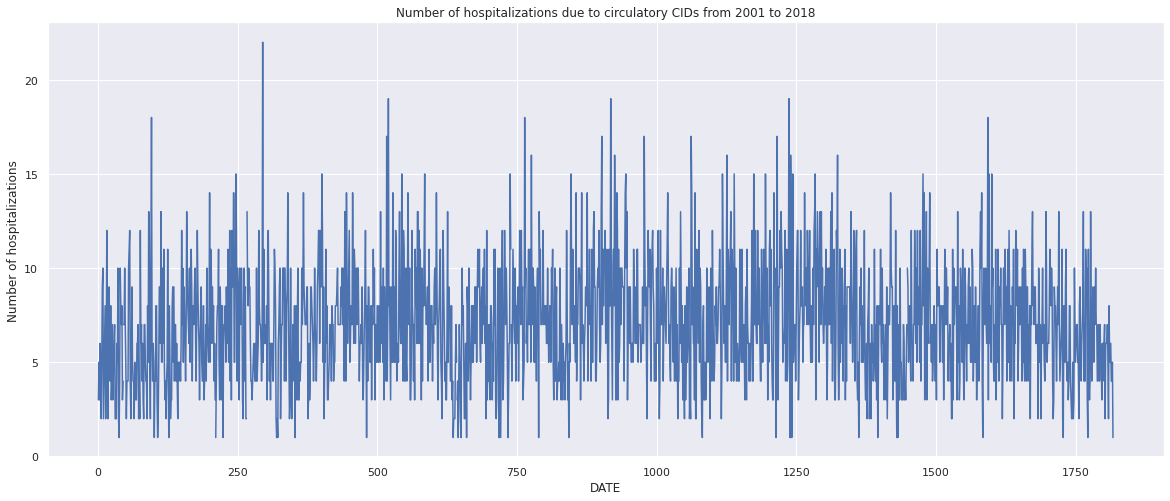

In [7]:
#Basic plot of number of hospitalizations
plt.figure(figsize=(20,8))
df.HOSP.plot()
plt.title('Number of hospitalizations due to circulatory CIDs from 2001 to 2018')
plt.ylabel('Number of hospitalizations')
plt.xlabel('DATE')
plt.show()

In [8]:
# data is overdispersed: variance is greater than the mean
print('variance = '+str(df['HOSP'].var()))
print('mean = '+str(df['HOSP'].mean()))

variance = 9.99538378360038
mean = 7.082553659878921


In [9]:
# add derived regression variables: month, day of week and strata
df = df.set_index('DATE')
ds2 = df.index.to_series()
df['MONTH'] = ds2.dt.month
df['DAY_OF_WEEK'] = ds2.dt.dayofweek
df['STRATA'] = ds2.dt.strftime('%Y-%m')
df['STRATA'] = df['STRATA'].astype("category").astype('category').cat.codes

#**Generalized Poisson Regression Hosp**

##**Temperature**

In [ ]:
#set the regression expression in patsy notation

expr = """HOSP ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +above_temp_range"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

         Current function value: 2.490662
         Iterations: 37
         Function evaluations: 87
         Gradient evaluations: 75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                   HOSP   No. Observations:                 1817
Model:             GeneralizedPoisson   Df Residuals:                     1811
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                 0.02047
Time:                        14:01:16   Log-Likelihood:                -4525.5
converged:                      False   LL-Null:                       -4620.1
Covariance Type:            nonrobust   LLR p-value:                 6.065e-39
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8824      3.820     -0.755      0.451     -10.370       4.605
DAY_OF_WEEK         -0.0627      0.005    -12.470      0.000      -0.073      -0.053
STRATA               0.0013      0.001      2.238      0.025       0.000       0.002
TMIN                -0.0142      0.004     -3.381      0.001      -0.022      -0.006
AVGPRESSURE          0.0056      0.004      1.387      0.165      -0.002       0.013
above_temp_range    -0.0481      0.043     -1.123      0.261      -0.132       0.036
alpha                0.0181      0.003      6.715      0.000       0.013       0.023
====================================================================================
"""

In [ ]:
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.056002,99.969044,0.000031
DAY_OF_WEEK,0.939258,0.948555,0.930053
STRATA,1.001327,1.002490,1.000165
TMIN,0.985918,0.994056,0.977847
AVGPRESSURE,1.005570,1.013494,0.997708
above_temp_range,0.952994,1.036531,0.876191
alpha,1.018246,1.023634,1.012886


In [ ]:
#set the regression expression in patsy notation

expr = """HOSP ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +above_temp_dif"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.490925
         Iterations: 40
         Function evaluations: 51
         Gradient evaluations: 51


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                   HOSP   No. Observations:                 1817
Model:             GeneralizedPoisson   Df Residuals:                     1811
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                 0.02036
Time:                        14:01:16   Log-Likelihood:                -4526.0
converged:                       True   LL-Null:                       -4620.1
Covariance Type:            nonrobust   LLR p-value:                 9.701e-39
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.7368      3.772     -0.991      0.322     -11.129       3.655
DAY_OF_WEEK       -0.0625      0.005    -12.427      0.000      -0.072      -0.053
STRATA             0.0014      0.001      2.335      0.020       0.000       0.003
TMIN              -0.0131      0.004     -3.156      0.002      -0.021      -0.005
AVGPRESSURE        0.0064      0.004      1.627      0.104      -0.001       0.014
above_temp_dif     0.0501      0.089      0.564      0.573      -0.124       0.224
alpha              0.0181      0.003      6.722      0.000       0.013       0.023
==================================================================================
"""

In [ ]:
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.023831,38.679227,0.000015
DAY_OF_WEEK,0.939379,0.948690,0.930160
STRATA,1.001380,1.002540,1.000221
TMIN,0.987005,0.995055,0.979020
AVGPRESSURE,1.006457,1.014289,0.998686
above_temp_dif,1.051428,1.251572,0.883290
alpha,1.018273,1.023663,1.012911


##**Pressure**

In [ ]:
#set the regression expression in patsy notation

expr = """HOSP ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +LPW"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.489346
         Iterations: 39
         Function evaluations: 50
         Gradient evaluations: 50


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                   HOSP   No. Observations:                 1817
Model:             GeneralizedPoisson   Df Residuals:                     1811
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                 0.02098
Time:                        14:01:16   Log-Likelihood:                -4523.1
converged:                       True   LL-Null:                       -4620.1
Covariance Type:            nonrobust   LLR p-value:                 5.761e-40
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -6.5578      3.942     -1.664      0.096     -14.283       1.168
DAY_OF_WEEK    -0.0630      0.005    -12.542      0.000      -0.073      -0.053
STRATA          0.0014      0.001      2.299      0.022       0.000       0.003
TMIN           -0.0118      0.004     -2.846      0.004      -0.020      -0.004
AVGPRESSURE     0.0094      0.004      2.276      0.023       0.001       0.018
LPW             0.1691      0.068      2.490      0.013       0.036       0.302
alpha           0.0179      0.003      6.646      0.000       0.013       0.023
===============================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.001419,3.214392,6.264624e-07
DAY_OF_WEEK,0.938983,0.948267,9.297902e-01
STRATA,1.001357,1.002515,1.000200e+00
TMIN,0.988230,0.996322,9.802033e-01
AVGPRESSURE,1.009454,1.017668,1.001306e+00
LPW,1.184187,1.352748,1.036630e+00
alpha,1.018026,1.023404,1.012676e+00


In [ ]:
#set the regression expression in patsy notation

expr = """HOSP ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +HPW"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.490807
         Iterations: 36
         Function evaluations: 47
         Gradient evaluations: 47


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                   HOSP   No. Observations:                 1817
Model:             GeneralizedPoisson   Df Residuals:                     1811
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                 0.02041
Time:                        14:01:17   Log-Likelihood:                -4525.8
converged:                       True   LL-Null:                       -4620.1
Covariance Type:            nonrobust   LLR p-value:                 7.852e-39
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.1671      4.172     -1.238      0.216     -13.345       3.011
DAY_OF_WEEK    -0.0625      0.005    -12.436      0.000      -0.072      -0.053
STRATA          0.0014      0.001      2.379      0.017       0.000       0.003
TMIN           -0.0124      0.004     -2.929      0.003      -0.021      -0.004
AVGPRESSURE     0.0079      0.004      1.815      0.070      -0.001       0.017
HPW            -0.0324      0.038     -0.862      0.389      -0.106       0.041
alpha           0.0181      0.003      6.717      0.000       0.013       0.023
===============================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.005701,20.298233,0.000002
DAY_OF_WEEK,0.939380,0.948684,0.930168
STRATA,1.001408,1.002570,1.000248
TMIN,0.987637,0.995893,0.979450
AVGPRESSURE,1.007979,1.016668,0.999364
HPW,0.968124,1.042110,0.899391
alpha,1.018254,1.023644,1.012893


In [ ]:
#set the regression expression in patsy notation

expr = """HOSP ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +above_pressure_dif"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.490685
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 46


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                   HOSP   No. Observations:                 1817
Model:             GeneralizedPoisson   Df Residuals:                     1811
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                 0.02046
Time:                        14:01:17   Log-Likelihood:                -4525.6
converged:                       True   LL-Null:                       -4620.1
Covariance Type:            nonrobust   LLR p-value:                 6.320e-39
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.9336      3.775     -1.042      0.297     -11.332       3.465
DAY_OF_WEEK           -0.0627      0.005    -12.481      0.000      -0.073      -0.053
STRATA                 0.0014      0.001      2.346      0.019       0.000       0.003
TMIN                  -0.0128      0.004     -3.088      0.002      -0.021      -0.005
AVGPRESSURE            0.0066      0.004      1.677      0.094      -0.001       0.014
above_pressure_dif     0.0367      0.034      1.092      0.275      -0.029       0.103
alpha                  0.0181      0.003      6.718      0.000       0.013       0.023
======================================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.019573,31.982443,0.000012
DAY_OF_WEEK,0.939199,0.948497,0.929993
STRATA,1.001387,1.002547,1.000228
TMIN,0.987274,0.995333,0.979280
AVGPRESSURE,1.006660,1.014500,0.998880
above_pressure_dif,1.037367,1.107973,0.971260
alpha,1.018255,1.023644,1.012895


##**Humidity**

In [ ]:
#set the regression expression in patsy notation

expr = """HOSP ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +LHW"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.489750
         Iterations: 37
         Function evaluations: 48
         Gradient evaluations: 48


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                   HOSP   No. Observations:                 1817
Model:             GeneralizedPoisson   Df Residuals:                     1811
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                 0.02082
Time:                        14:01:17   Log-Likelihood:                -4523.9
converged:                       True   LL-Null:                       -4620.1
Covariance Type:            nonrobust   LLR p-value:                 1.186e-39
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.1126      3.767     -1.092      0.275     -11.495       3.270
DAY_OF_WEEK    -0.0626      0.005    -12.462      0.000      -0.072      -0.053
STRATA          0.0014      0.001      2.288      0.022       0.000       0.003
TMIN           -0.0128      0.004     -3.096      0.002      -0.021      -0.005
AVGPRESSURE     0.0068      0.004      1.731      0.083      -0.001       0.015
LHW            -0.0836      0.039     -2.128      0.033      -0.161      -0.007
alpha           0.0179      0.003      6.663      0.000       0.013       0.023
===============================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.016365,26.310602,0.000010
DAY_OF_WEEK,0.939347,0.948636,0.930149
STRATA,1.001352,1.002511,1.000194
TMIN,0.987301,0.995322,0.979345
AVGPRESSURE,1.006862,1.014687,0.999096
LHW,0.919791,0.993409,0.851629
alpha,1.018081,1.023463,1.012729


In [ ]:
#set the regression expression in patsy notation

expr = """HOSP ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +HHW"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.490979
         Iterations: 43
         Function evaluations: 54
         Gradient evaluations: 54


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                   HOSP   No. Observations:                 1817
Model:             GeneralizedPoisson   Df Residuals:                     1811
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                 0.02034
Time:                        14:01:17   Log-Likelihood:                -4526.1
converged:                       True   LL-Null:                       -4620.1
Covariance Type:            nonrobust   LLR p-value:                 1.068e-38
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.6930      3.772     -0.979      0.328     -11.086       3.700
DAY_OF_WEEK    -0.0627      0.005    -12.472      0.000      -0.073      -0.053
STRATA          0.0014      0.001      2.340      0.019       0.000       0.003
TMIN           -0.0133      0.004     -3.213      0.001      -0.021      -0.005
AVGPRESSURE     0.0064      0.004      1.616      0.106      -0.001       0.014
HHW             0.0654      0.188      0.349      0.727      -0.302       0.433
alpha           0.0181      0.003      6.725      0.000       0.013       0.023
===============================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.024896,40.446355,0.000015
DAY_OF_WEEK,0.939242,0.948540,0.930035
STRATA,1.001383,1.002544,1.000225
TMIN,0.986828,0.994841,0.978879
AVGPRESSURE,1.006414,1.014248,0.998642
HHW,1.067615,1.541817,0.739259
alpha,1.018283,1.023674,1.012920


In [ ]:
#set the regression expression in patsy notation

expr = """HOSP ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE + above_humidity_range"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.490994
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 46


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                   HOSP   No. Observations:                 1817
Model:             GeneralizedPoisson   Df Residuals:                     1811
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                 0.02034
Time:                        14:01:17   Log-Likelihood:                -4526.1
converged:                       True   LL-Null:                       -4620.1
Covariance Type:            nonrobust   LLR p-value:                 1.097e-38
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.6895      3.776     -0.977      0.329     -11.090       3.711
DAY_OF_WEEK             -0.0627      0.005    -12.464      0.000      -0.073      -0.053
STRATA                   0.0014      0.001      2.349      0.019       0.000       0.003
TMIN                    -0.0133      0.004     -3.210      0.001      -0.021      -0.005
AVGPRESSURE              0.0064      0.004      1.614      0.107      -0.001       0.014
above_humidity_range     0.0078      0.030      0.256      0.798      -0.052       0.067
alpha                    0.0181      0.003      6.725      0.000       0.013       0.023
========================================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.024985,40.901006,0.000015
DAY_OF_WEEK,0.939269,0.948569,0.930060
STRATA,1.001394,1.002559,1.000231
TMIN,0.986833,0.994853,0.978877
AVGPRESSURE,1.006409,1.014250,0.998629
above_humidity_range,1.007818,1.069613,0.949593
alpha,1.018282,1.023673,1.012919


In [ ]:
#set the regression expression in patsy notation

expr = """HOSP ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +above_humidity_dif"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.490910
         Iterations: 40
         Function evaluations: 51
         Gradient evaluations: 51


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                   HOSP   No. Observations:                 1817
Model:             GeneralizedPoisson   Df Residuals:                     1811
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                 0.02037
Time:                        14:01:18   Log-Likelihood:                -4526.0
converged:                       True   LL-Null:                       -4620.1
Covariance Type:            nonrobust   LLR p-value:                 9.451e-39
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.6127      3.766     -0.959      0.337     -10.993       3.768
DAY_OF_WEEK           -0.0627      0.005    -12.481      0.000      -0.073      -0.053
STRATA                 0.0014      0.001      2.348      0.019       0.000       0.003
TMIN                  -0.0133      0.004     -3.230      0.001      -0.021      -0.005
AVGPRESSURE            0.0063      0.004      1.598      0.110      -0.001       0.014
above_humidity_dif     0.0563      0.092      0.610      0.542      -0.125       0.237
alpha                  0.0181      0.003      6.724      0.000       0.013       0.023
======================================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.026979,43.281509,0.000017
DAY_OF_WEEK,0.939185,0.948485,0.929977
STRATA,1.001388,1.002548,1.000229
TMIN,0.986771,0.994777,0.978830
AVGPRESSURE,1.006329,1.014148,0.998570
above_humidity_dif,1.057932,1.267685,0.882885
alpha,1.018278,1.023668,1.012916


#**References**

P. C. Consul,Generalized Poisson distributions: properties and applications.  M. Dekker, 1989.